# Configuration - Important

In [1]:
billboard100_flag = True  # If true the top100_billboard database is already created and stored and therefore will be loaded
spotifydb_flag = True  # If true the spotify songs database is already created and stored and therefore will be loaded
kmeans_flag = True # If true the clustering model is already created and stored and therefore will be loaded

# Importing Modules

In [2]:
# General
import pandas as pd
import numpy as np
import ipywidgets as widgets
import IPython.display
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import jaro
import time
from IPython.display import IFrame

# Spotify API
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy
import config

# Web Scrapping
from bs4 import BeautifulSoup
import requests

# Modelling
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# User Defined Functions

## Web Scrapping

In [3]:
def billboard100_scrapper(url):
    """
    

    Parameters
    ----------
    url : String
        The URL where billboard Top100 is stored.

    Returns
    -------
    output : DataFrame
        The Billboard Top100 scrapped from the web and stored in a DataFrame.

    """

    res = []
    columns = ["song", "artist", "last_week", "peak_pos", "n_weeks"]

    # requesting and downloading the URL
    response = requests.get(url)

    # parsing the html
    soup = BeautifulSoup(response.content, "html.parser")

    # storing the html code containing the top100 data in a variable
    rows = soup.select(".o-chart-results-list-row")

    # looping through the html code
    for row in rows:

        lst = row.get_text().split("\n") # get the content of the html code and store in a list (without \n)

        lst_clean = [string.lower() for string in lst if len(string) > 0] # clean the \n from the list

        if lst_clean[1] == "new": # special treatment for rows with a new comer

            res.append(lst_clean[3:-3])

        elif lst_clean[1] == "re-": # special treatment for rows with RE-ENTER

            res.append(lst_clean[5:-3])
        
        else:

            res.append(lst_clean[1:-3])

            
    output = pd.DataFrame(res, columns=["song", "artist", "last_week", "peak_pos", "n_weeks"]) # output DataFrame
    output["source"] = "billboard100"

    # Saving the billboard 100 database
    output.to_csv("Data/billboard100.csv", index=False)

    return output

## Spotify

In [4]:
def genredb_builder(max_songs=1000):
    """
    Generates a database of spotify. The database will contain "max_songs" for 
    each genre in "sp.recommendation_genre_seeds()."

    Parameters
    ----------
    max_songs : Integer, optional
        Maximum number of song per genre to be queried. The default is 1000.

    Returns
    -------
    songs_db : DataFrame
        A database of Spotify songs containing:
            - Song Name
            - Song ID
            - Song Genre
            - Song Artist
            - Song Popularity
    n_genres : Integer
        Number of unique genres in the dabase (with at least one song).
    genre_popularity_df : DataFrame
        Contains the popularity (calculated as the mean popularity of its songs) for all the genres.

    """

    genredb_dict = {}
    genre_pop_dict = {}
    counter = 0

    genres_list = sp.recommendation_genre_seeds()["genres"]

    genre_pop_dict["genre"] = []
    genre_pop_dict["popularity"] = []

    for genre in tqdm(genres_list):

        genredb_dict["name"] = []
        genredb_dict["id"] = []
        genredb_dict["genre"] = []
        genredb_dict["artist"] = []
        genredb_dict["popularity"] = []

        for offset in range(0, max_songs, 50):

            # Querying the data to Spotify API
            res = sp.search(f'genre:{genre}', type="track", limit=50, offset=offset)

            # Looping through the response and storing the song name, id, genre and popularity in a dictionary
            for track in range(len(res["tracks"]["items"])):

                    genredb_dict["name"].append(res["tracks"]["items"][track]["name"])
                    genredb_dict["id"].append(res["tracks"]["items"][track]["id"])
                    genredb_dict["genre"].append(genre)
                    genredb_dict["artist"].append(res["tracks"]["items"][track]["artists"][0]["name"])
                    genredb_dict["popularity"].append(res["tracks"]["items"][track]["popularity"])
        
        # Creating a DataFrame from the dictionary for each genre
        genredb_df = pd.DataFrame(genredb_dict)

        # Creating the complete db Dataframe and concatenating to it each of the genres data
        if counter==0:

            songs_db = genredb_df

        else:

            songs_db = (pd.concat([songs_db, genredb_df], axis=0)
                       .reset_index(drop=True)
                       )

        # Calulating the genre popularity and storing it in a DataFrame
        genre_popularity = np.mean(genredb_df["popularity"])
        genre_pop_dict["genre"].append(genre)
        genre_pop_dict["popularity"].append(genre_popularity)

        counter += 1

    # Calculating the number of unique genres (that have at least one song)
    n_genres = len(set(songs_db["genre"]))

    # Creating the genre popularity DataFrame (sorted by popularity)
    genre_popularity_df = (pd.DataFrame(genre_pop_dict)
                           .sort_values(by="popularity", ascending=False)
                           .reset_index(drop=True)
                           )
    
    # Saving the database and the genre_popularity_df
    songs_db.to_csv(f'Data/songs_db.csv', index=False)
    genre_popularity_df.to_csv(f'Data/genre_popularity_df.csv', index=False)


    return songs_db, n_genres, genre_popularity_df


In [5]:
def audiofeatures_builder(songs_db):
    """
    

    Parameters
    ----------
    songs_db : DataFrame
        Contains a database of Spotify songs with the corresponding ID (assumed the ID is column 1).

    Returns
    -------
    songs_db : DataFrame
        The songs databses with the corresponding audio features.

    """


    # Creating batches of the songs_db - size 100
    chunk_size = 100
    list_chunks = [songs_db[i:i+chunk_size] for i in range(0, len(songs_db), chunk_size)]

    # For each batch, a query to Spotify API is sent requesting the corresponding audio features
    for i, batch in tqdm(enumerate(list_chunks)):
            
            id_list = list(batch["id"])
            audio_features = sp.audio_features(tracks=id_list)

            if i==0:

                audio_features_df = pd.DataFrame(audio_features)

            else:

                audio_features_df = pd.concat([audio_features_df, pd.DataFrame(audio_features)], axis=0)

    # The audio_features_df is filtered to contain only the relevant data
    audio_features_df = (audio_features_df.iloc[:, 0:11]
                                          .reset_index(drop=True)
                        )
    # Columns with NA are dropped, if any
    songs_db = (pd.concat([songs_db, audio_features_df], axis=1)
                .dropna()
               )

    # The database is saved         
    songs_db.to_csv("Data/songs_audiofeatures_db.csv", index=False)

    return songs_db

## Clustering

In [6]:
def kmeans_modelling(spotifydb, n_clusters=6, n_init=20, tol=0, score=False):
    """
    

    Parameters
    ----------
    spotifydb : DataFrame
        A DataFrame containing songs and their correspoding spotify audiofeatures.
    n_clusters : Integer, optional
        The number of cluester of the Kmeans clustering. The default is 6.
    n_init : Integer, optional
        Number of time the k-means algorithm will be run with different centroid seeds. The default is 20.
    tol : Float, optional
        Relative tolerance with regards to Frobenius norm of the difference in the cluster centers of two consecutive iterations to declare convergence. 
        The default is 0.
    score : Boolean, optional
        Set it to true and the model Silohuette score will be calculated. The default is False.

    Returns
    -------
    kmeans : Sklearn Model Object
        The fitted kmeans model.
    scaler : Sklearn Standard Numerical Scaler Object.
        The scaler object used to scale the audio features previous to the clustering.
    score : the model Silhouette score
    spotifydb : DataFrame
        The input DataFrame with an additional column, the predicted cluster.

    """
    spotifydb_clustered = spotifydb.copy()

    # Selecting the features and scaling them
    audiofeatures = spotifydb_clustered .iloc[:, 5:]
    scaler = StandardScaler()
    scaler.fit(audiofeatures)
    x_scaled = scaler.transform(audiofeatures)
    audiofeatures_scaled = pd.DataFrame(x_scaled, columns=audiofeatures.columns)

    # Clustering the songs with the audio features
    kmeans = KMeans(n_clusters=n_clusters, 
                    random_state=0,
                    n_init=n_init,
                    tol=tol,
                    algorithm="elkan",
                    init="k-means++"
                    )

    kmeans.fit(audiofeatures_scaled)
    spotifydb_clustered["cluster"] = kmeans.labels_

    # Calculating the silhouette score
    if score:
        score = silhouette_score(audiofeatures_scaled, kmeans.labels_)
    else:
        score = None

    # Saving the database, the kmeans model and the scaler
    spotifydb_clustered.to_csv(f'Data/Models/songs_clustered_{n_clusters}clusters_db.csv', index=False)

    with open(f'Data/Models/kmeans_model_{n_clusters}clusters.pickle', "wb") as f:

        pickle.dump(kmeans, f)

    with open("Data/Models/scaler.pickle", "wb") as f:

        pickle.dump(scaler, f)

    return kmeans, scaler, score, spotifydb_clustered


## Song Recommendation

In [7]:
# A wrapper function of the Spotify Player Widget

def spotify_player(song_id):
    track_id = song_id
    player = IFrame(src=f"https://open.spotify.com/embed/track/{track_id}",
             width="320",
             height="80",
             frameborder="0",
             allowtransparency="true",
             allow="encrypted-media",
            )
    return player

In [8]:
def hot_recommender_v3(songs_data):
    """
    This function takes a hot songs database and asks the users for a song they love. The function compares the user
    input with the songs in the dabase and provides a recommendation if the user input song is in the function
    input hot songs database. One of the main features of the tool is its capability to catch user input typos using
    Jaro-Winkler ratio.

    Parameters
    ----------
    songs_data : DataFrame
        The hot songs database.

    Returns
    -------
    None.

    """
    
    # Converting the song and artist data to numpy arrays
    songs = np.array(songs_data["song"])
    artists = np.array(songs_data["artist"])
    
    # Flow control Flags
    hotsong_match = False  # True if the input song is in the hot songs db
    on = True  # True while the recommender should be running (according to users input)

    while on:
        
        # Requesting the song name to the users. It is converted to lower cases to standarize the input.
        user_song = input("Please enter the name of one hot song you love: ").lower()
        print("--------------------------")

        # In this loop user_song is compared against all the songs in hot songs db using
        # Jaro-Winkler formula (https://pypi.org/project/jaro-winkler/). Jaro-Winkler formula compares 
        # two strings and finds a ratio of simmilarity (1 equal, 0 totally different). If the ratio is >0.9 
        # and not equal to 1 the programm considers that the user input had a typo and asks the users if 
        # they meant the corresponding song in the hot songs db.
        # If Jaro-Winkler ratio = 1, the user_input is in the hot songs db.
        
        for song in songs:

            jaro_rating = jaro.jaro_winkler_metric(user_song, song)

            if jaro_rating > 0.92:

                user_song = song

                if jaro_rating == 1:

                    hotsong_match = True # Jaro ratio = 1, the users input is in the hot songs db

                else:

                    answer_typo = input(f'Do you mean "{user_song}"?')
                    print("--------------------------")

                    if answer_typo in ["yes", "y"]:

                        hotsong_match = True # There was a typo, the users input is in the hot songs db
                
                    # This protoype does not deal with the possibility that the user answers no
                    # This is solved in second protoype
                
                break

        # If the users song is in the hot songs db a random song from the db is selected
        # The possibilty that one song name has more than one artist is also considered. In this case a
        # random artist is selected for the recommendation song/artist.
        
        if hotsong_match:

            recommended_song = np.random.choice(songs).title()
            index = np.where(songs == recommended_song.lower())[0]

            if len(index) == 1:

                recommended_artist = artists[index[0]].title()

            else:

                recommended_artist = artists[np.random.choice(index)].title()

            print(f'We think "{recommended_song}" from "{recommended_artist}" will like you. Check it out!')
            print("--------------------------")
        
        # If the users song is not in the hot songs db the users are informed and asked if they want another
        # recommendation.
        
        else:

            print("The song you provided us is not popular at the moment. Please try again with a hot song.")
            print("--------------------------")

        time.sleep(1)
        cont = input("Do you want another recommendation? ").lower()
        print("--------------------------")

        if cont in ["y", "yes"]:

            print("Awesome! :)")
            print("--------------------------")
            
            hotsong_match = False  # The hotsong_match Flag is reseted

        else:

            print("That's a pity :( See you next time!")
            print("--------------------------")
            on = False  # The users do not want another recommendation, the flag is turn False and the programm stops

    return

In [9]:
def song_recommender_V2(hot_songs_db, songs_db, kmeans_model, scaler, limit=1):
    """
    This function takes a hot songs database and a general songs db and asks the users for a song they love. The programm flow is:
        
        1) The user song is compared with the hot songs database. One of the main features of the tool is its capability to catch 
        user input typos using Jaro-Winkler ratio.
                 
            1.a)  If the user input song is in the function input hot songs database a hot song recommendation is provided.
                  The user is given also the option to use the audio features based recommender (see 2)
            1.b)  The song is not contained in the hot songs db (see 2)
    
        2) A recommendation is given to the user based on the user song Spotify audio features. The user song audio features are scaled
           using the input scaler and a cluster is assigned based on the input Kmeans model. A random song from the input general songs db
           is selected as recommendation (from the same cluster group)
        

    Parameters
    ----------
    hot_songs_db : DataFrame
        A hot songs databse.
    songs_db : DataFrame
        A general songs database.
    kmeans_model : Sklearn Model Object
        A kmeans model fitted using the songs_db.
    scaler : Sklearn numerical standard scaler object
        The scaler object used during the model creation of the kmeans model.
    limit : integer, optional
        Number of songs to show to the users from the Spotify query of their input song . The default is 1.

    Returns
    -------
    None.

    """

    columns_names = ['danceability', 'energy', 'key', 'loudness',
                     'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
                     'valence', 'tempo'
                     ]
    # Converting the hot songs and artist data to numpy arrays
    hot_songs = np.array(hot_songs_db["song"])
    hot_artists = np.array(hot_songs_db["artist"])

    # Flow control Flags
    hotsong_match = False  # True if the input song is in the hot songs db
    feature_recommender = True  # True if the audio features based recommender should be used based on user inputs
    song_exist = True  # True if the user song is found on the Spotify database
    on = True  # True while the recommender should be running (according to users input)

    # Welcoming the user
    print("Welcome to the NHero Song Recommender - Developer Environment. Please bear in mind this is a beta version.")
    print("--------------------------")

    time.sleep(0.75)

    while on:

        # Initializing the variables
        audio_f_list = []
        row = []

        # Requesting the song name to the users. It is converted to lower cases to standarize the input.
        user_song = input("Please enter the name of one song you love: ").lower()
        print("--------------------------")

        # In this loop user_song is compared against all the songs in hot songs db using
        # Jaro-Winkler formula (https://pypi.org/project/jaro-winkler/). Jaro-Winkler formula compares 
        # two strings and finds a ratio of simmilarity (1 equal, 0 totally different). If the ratio is >0.9 
        # and not equal to 1 the programm considers that the user input had a typo and asks the users if 
        # they meant the corresponding song in the hot songs db.
        # If Jaro-Winkler ratio = 1, the user_input is in the hot songs db.

        for song in hot_songs:

            jaro_rating = jaro.jaro_winkler_metric(user_song, song)

            if jaro_rating > 0.92:

                user_song = song

                if jaro_rating == 1:

                    hotsong_match = True  # Jaro ratio = 1, the users input is in the hot songs db

                else:

                    answer_typo = input(f'Do you mean "{user_song}"? ')
                    print("--------------------------")

                    if answer_typo in ["yes", "y"]:

                        hotsong_match = True  # There was a typo, the users input is in the hot songs db

                    else:

                        # The user acutally meant a song that is not the hot song db. 
                        print("Oh, then you won't probably like our hot song recommendation. Let's try our song features based recommender!")
                        print("--------------------------")
                break

        # If the users song is in the hot songs db a random song from the db is selected
        # The possibilty that one song name has more than one artist is also considered. In this case a
        # random artist is selected for the recommendation song/artist.

        if hotsong_match:

            recommended_song = np.random.choice(hot_songs).title()
            recommended_id = sp.search(q=recommended_song, type="track", limit=1, market="US")["tracks"]["items"][0]["id"]
            recommended_index = np.where(hot_songs == recommended_song.lower())[0]

            if len(recommended_index) == 1:

                recommended_artist = hot_artists[recommended_index[0]].title()

            else:

                recommended_artist = hot_artists[np.random.choice(recommended_index)].title()

            # The user song and the corresponding artist (contained in the hot songs db) is printed
            user_index = np.where(hot_songs == user_song.lower())[0]
            user_artist = hot_artists[user_index[0]].title()

            # The recommended song is printed. A Spotify player widget with the recommendation is also provided
            print(f'Your song: {user_song.title()} / {user_artist}')
            print(f'You are into hot songs! We think "{recommended_song}" from "{recommended_artist}" will like you. Check it out!')
            print("--------------------------")
            player = spotify_player(recommended_id)
            IPython.display.display(player)
            print("--------------------------")

            # The user is also given the option to jump to the audio features based recommender
            feature_recommender_ans = input(f'Are you not satisfied with the hot song recommendation? '
                             f'Do you wanna try our amazing song featured based recommender? ')
            print("--------------------------")

            if feature_recommender_ans in ["yes", "y"]:

                feature_recommender = True

            else:

                feature_recommender = False

        
        if feature_recommender:


            # Checking if the user song gives a result on Spotify API
            # If not, checked with the users if there was a typo. The checking routine will keep checking until:
            # a - the user confirms is not a typo. The programm asks if the user wants another recommendation
            # b - the user enters another song that can be find on Spotify API
        
            try:

                user_tracks = sp.search(q=user_song, type="track", limit=limit, market="US")["tracks"]["items"]
                test = user_tracks[0]
                song_exist = True  # The user song is found on Spotify API

            except IndexError:

                odd_error = True

                while odd_error:

                    odd_ans = input(f'There is something odd! Do you really mean {user_song}? ')
                    print("--------------------------")

                    if odd_ans in ["yes", "y"]:

                        print("You have a weird taste! Your song is not in Spotify Database!")
                        print("--------------------------")
                        song_exist = False  # The user song is not on Spotify API, the programm will jump to ask the user if he want another recommendation
                        odd_error = False

                    else:

                        user_song = input("Ops! Please enter again your song: ").lower()
                        print("--------------------------")

                        try:

                            user_tracks = sp.search(q=user_song, type="track", limit=limit, market="US")["tracks"]["items"]
                            test = user_tracks[0]
                            odd_error = False
                            song_exist = True  # The user song is found on Spotify API

                        except IndexError:

                            pass

            if song_exist:

                # Initialize the variables required for the audio features based recommender
                sp_response_song_list = []
                sp_response_artist_list = []

                # If limit==1 the user selected to show only one Spotity result
                if limit == 1:

                    user_song_id = user_tracks[0]["id"]
                    user_artist = user_tracks[0]["artists"][0]["name"]

                # If limit>1 n=limit options are presented to the users and they have to selected which one they want
                if limit > 1:

                    for i in range(len(user_tracks)):

                        sp_response_song_list.append(user_tracks[i]["name"])
                        sp_response_artist_list.append(user_tracks[i]["artists"][0]["name"])

                    print("Spotify found more than one song under that name!")
                    print()

                    for j in range(len(sp_response_song_list)):

                        print(f'{j+1}. {sp_response_song_list[j]} / {sp_response_artist_list[j]}')

                    print("--------------------------")

                    song_sel_ans = int(input(f'Which one do you mean? '))
                    print("--------------------------")
                    user_song = sp_response_song_list[song_sel_ans - 1]
                    user_song_id = user_tracks[song_sel_ans - 1]["id"]
                    user_artist = user_tracks[song_sel_ans - 1]["artists"][0]["name"]

                # A query to Spotify API to get the user song audio features
                audio_features = sp.audio_features(user_song_id)
                audio_features = pd.DataFrame(audio_features, columns=columns_names)

                # Using the input kmeans model and scaler a cluster is asigned to the user song
                x_scaled = scaler.transform(audio_features)
                audio_features_scaled = pd.DataFrame(x_scaled, columns=columns_names)
                user_song_cluster = kmeans_model.predict(audio_features_scaled)

                # A random song contained in the input songs db and from the same cluster is selected as recommendation
                recommendation = songs_db[songs_db["cluster"] == user_song_cluster[0]].sample()
                recommendation_song = recommendation["name"].iloc[0]
                recommendation_artist = recommendation["artist"].iloc[0]
                recommendation_id = recommendation["id"].iloc[0]

                # The user song and the corresponding artist  is printed
                print(f'Your song: {user_song.title()} / {user_artist.title()}')

                # The recommended song is printed. A Spotify player widget with the recommendation is also provided
                print(f'Based on the song features we think "{recommendation_song}" from "{recommendation_artist}" will like you. Check it out!')
                print("--------------------------")
                player = spotify_player(recommendation_id)
                IPython.display.display(player)
                print("--------------------------")

        time.sleep(0.75)
        cont = input("Do you want another recommendation? ").lower()
        print("--------------------------")

        if cont in ["y", "yes"]:

            print("Awesome! :)")
            print("--------------------------")

            hotsong_match = False  # The hotsong_match Flag is reseted

        else:

            print("That's a pity :( See you next time!")
            print("--------------------------")
            on = False

    return


# Creating the songs databases

## Top100 Billboard

In [10]:
if billboard100_flag:

    billboard100 = pd.read_csv("Data/billboard100.csv")

else:

    billboard100 = billboard100_scrapper("https://www.billboard.com/charts/hot-100/")

## Spotify Database

In [11]:
# Initialize SpotiPy with user credentials

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id= config.client_id,
                                                           client_secret= config.client_secret))

In [12]:
if spotifydb_flag:

    # we load the songs database with the audifeatures data, input for the modelling
    spotifydb = pd.read_csv("Data/songs_audiofeatures_db.csv")
    n_genres = len(set(spotifydb["genre"]))
    genres_popularity = pd.read_csv("Data/genre_popularity_df.csv")
        

else:

    spotifydb, n_genres, genres_popularity = genredb_builder(max_songs=1000)
    spotifydb = audiofeatures_builder(spotifydb)

Let us check the genres available in Spotify. We will select the more representatives genres, as many of these are very simmilar between them or very niche. We will filter our database to only contain songs of these genres.

In [13]:
genres_list = sp.recommendation_genre_seeds()["genres"]
print(genres_list)

['acoustic', 'afrobeat', 'alt-rock', 'alternative', 'ambient', 'anime', 'black-metal', 'bluegrass', 'blues', 'bossanova', 'brazil', 'breakbeat', 'british', 'cantopop', 'chicago-house', 'children', 'chill', 'classical', 'club', 'comedy', 'country', 'dance', 'dancehall', 'death-metal', 'deep-house', 'detroit-techno', 'disco', 'disney', 'drum-and-bass', 'dub', 'dubstep', 'edm', 'electro', 'electronic', 'emo', 'folk', 'forro', 'french', 'funk', 'garage', 'german', 'gospel', 'goth', 'grindcore', 'groove', 'grunge', 'guitar', 'happy', 'hard-rock', 'hardcore', 'hardstyle', 'heavy-metal', 'hip-hop', 'holidays', 'honky-tonk', 'house', 'idm', 'indian', 'indie', 'indie-pop', 'industrial', 'iranian', 'j-dance', 'j-idol', 'j-pop', 'j-rock', 'jazz', 'k-pop', 'kids', 'latin', 'latino', 'malay', 'mandopop', 'metal', 'metal-misc', 'metalcore', 'minimal-techno', 'movies', 'mpb', 'new-age', 'new-release', 'opera', 'pagode', 'party', 'philippines-opm', 'piano', 'pop', 'pop-film', 'post-dubstep', 'power-po

Let's check the top 30 genres in terms of popularity

In [14]:
top = 30
top_genres = list(genres_popularity.iloc[:top,:]["genre"])
top_genres


['pop',
 'rock',
 'dance',
 'alternative',
 'indie',
 'hip-hop',
 'country',
 'alt-rock',
 'indie-pop',
 'metal',
 'k-pop',
 'soul',
 'folk',
 'hard-rock',
 'jazz',
 'house',
 'blues',
 'emo',
 'edm',
 'punk',
 'songwriter',
 'singer-songwriter',
 'chill',
 'electro',
 'sad',
 'r-n-b',
 'j-pop',
 'grunge',
 'british',
 'punk-rock']

From this list we filter out those genres that are too similar to other or that are niche.

In [15]:
filter_out = ["indie-pop", "k-pop", "j-pop", "single-songwriter", "british", "punk-rock", "sad"]
my_genres = [g for g in top_genres if g not in filter_out]
my_genres_mask = spotifydb["genre"].apply(lambda x: x in my_genres)

spotifydb_mygenres = (spotifydb[my_genres_mask]
                      .reset_index(drop=True)
                      )

# Clustering

## Choosing n of Clusters

Let us iterate the modelling up to len(my_genres). The inertia data and the silohuette score for each model are saved in lists.

In [16]:
if not kmeans_flag:

    K = range(2, len(my_genres))
    inertia = []
    silhouette = []

    for k in tqdm(K):
        
        kmeans_model, scaler, score, spotifydb_clustered = kmeans_modelling(spotifydb_mygenres, n_clusters=k, score=True)

        inertia.append(kmeans_model.inertia_)
        silhouette.append(score)

In [17]:
# Saving the metrics data in a csv file or loading the data if kmeans_flag = True

if kmeans_flag:
    
    metrics_df = pd.read_csv("Data/metrics.csv")
    K = range(2, len(my_genres))
    inertia = list(metrics_df["inertia"])
    silhouette = list(metrics_df["silhouette"])
        
else:
    
    metrics_df = pd.DataFrame({"n_clusters": K, "inertia": inertia, "silhouette": silhouette})
    metrics_df.to_csv("Data/metrics.csv", index=False)

To help choose an optimal number of cluster we will use two methods/graphs: Elbow and Silhouette Methods

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

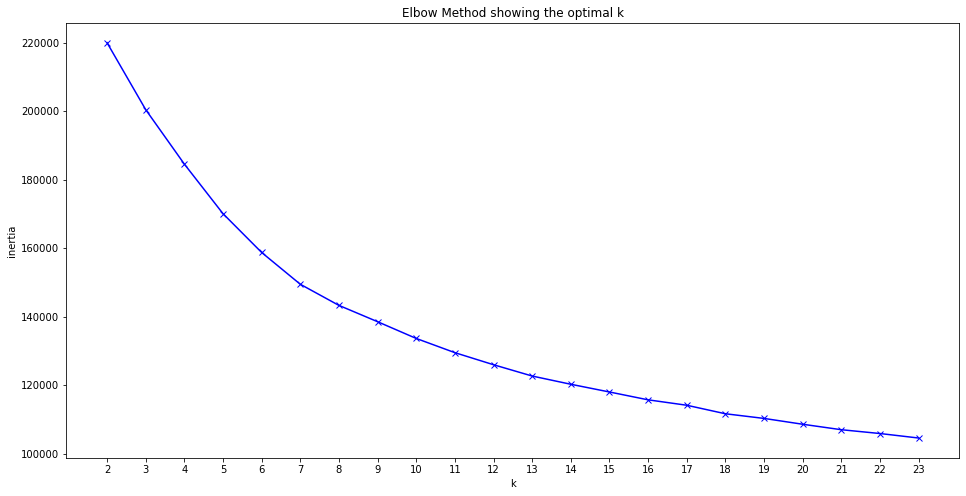

In [18]:
# Elbow Method

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

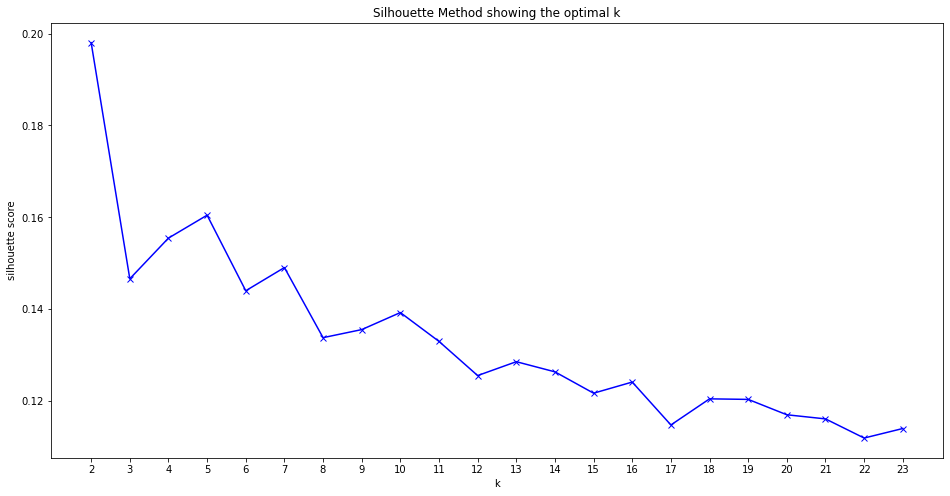

In [19]:
# Silhouette Method

plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette Method showing the optimal k')

Let us also create a model with n_clusters=len(my_genres)

In [20]:
if not kmeans_flag:

    kmeans_model, scaler, score, spotifydb_clustered = kmeans_modelling(spotifydb_mygenres, len(my_genres), n_init=20, tol=0, score=False)

## The final model

In [21]:
n_clusters = len(my_genres)

# Load the clustered db

spotifydb_clustered = pd.read_csv(f'Data/Models/songs_clustered_{n_clusters}clusters_db.csv')

# Load the kmeans model
with open(f'Data/Models/kmeans_model_{n_clusters}clusters.pickle', "rb") as f:
        
    kmeans_model = pickle.load(f)

# Load the numerical standard scaler
with open("Data/Models/scaler.pickle", "rb") as f:
        
    scaler = pickle.load(f)

In [22]:
spotifydb_clustered

,name,id,genre,artist,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
0,Sweater Weather,2QjOHCTQ1Jl3zawyYOpxh6,alt-rock,The Neighbourhood,92.0,0.612,0.807,10,-2.810,1,0.0336,0.049500,0.017700,0.1010,0.398,124.053,13
1,Daddy Issues,5E30LdtzQTGqRvNd7l6kG5,alt-rock,The Neighbourhood,89.0,0.588,0.521,10,-9.461,1,0.0329,0.067800,0.149000,0.1230,0.337,85.012,20
2,Everybody Talks,2iUmqdfGZcHIhS3b9E9EWq,alt-rock,Neon Trees,83.0,0.471,0.924,8,-3.906,1,0.0586,0.003010,0.000000,0.3130,0.725,154.961,22
3,Smells Like Teen Spirit,5ghIJDpPoe3CfHMGu71E6T,alt-rock,Nirvana,80.0,0.502,0.912,1,-4.556,1,0.0564,0.000025,0.000173,0.1060,0.720,116.761,12
4,Tongue Tied,0GO8y8jQk1PkHzS31d699N,alt-rock,Grouplove,82.0,0.560,0.936,3,-5.835,1,0.0439,0.008470,0.000000,0.1610,0.371,112.960,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,I've Been Loving You Too Long,4pdLyulbYLCrPmDzWWeJIZ,soul,Otis Redding,61.0,0.499,0.246,9,-12.806,1,0.0325,0.700000,0.002270,0.0965,0.152,148.468,16
23996,Uptight (Everything's Alright),0Hw6SCrtU9pFCjgAONpnGZ,soul,Stevie Wonder,57.0,0.593,0.642,5,-9.894,0,0.0304,0.186000,0.000000,0.1290,0.919,133.281,6
23997,Lens,371H6HjS4SXGbQ9IVfFUIL,soul,Frank Ocean,60.0,0.681,0.333,9,-8.582,1,0.0974,0.588000,0.000000,0.0860,0.564,118.050,11
23998,"My, My, My",0Z9FRM5zukGVagh8TVSdrI,soul,Johnny Gill,57.0,0.580,0.596,0,-10.310,1,0.0626,0.093000,0.000000,0.1090,0.653,74.033,12


# First Prototype, only hot recommender

In [30]:
hot_recommender_v3(billboard100)

Please enter the name of one hot song you love: easy on m
--------------------------
Do you mean "easy on me"?yes
--------------------------
We think "Good 4 U" from "Olivia Rodrigo" will like you. Check it out!
--------------------------
Do you want another recommendation? n
--------------------------
That's a pity :( See you next time!
--------------------------


# Second Prototype, fully functional

In [ ]:
song_recommender_V2(billboard100, spotifydb_clustered, kmeans_model, scaler, limit = 3)

Welcome to the NHero Song Recommender - Developer Environment. Please bear in mind this is a beta version.
--------------------------
Please enter the name of one song you love: easy on m
--------------------------
Do you mean "easy on me"? n
--------------------------
Oh, then you won't probably like our hot song recommendation. Let's try our song features based recommender!
--------------------------
Spotify found more than one song under that name!

1. Easy On Me / Adele
2. Easy On Me / No Resolve
3. Easy On Me / Adele
--------------------------
Which one do you mean? 3
--------------------------
Your song: Easy On Me / Adele
Based on the song features we think "Love Is A Losing Game" from "Amy Winehouse" will like you. Check it out!
--------------------------


--------------------------
Do you want another recommendation? y
--------------------------
Awesome! :)
--------------------------
Please enter the name of one song you love: doygsñgvkfñs
--------------------------
There is something odd! Do you really mean doygsñgvkfñs? n
--------------------------
Ops! Please enter again your song: fdmsñzgfaew´gl<v
--------------------------
There is something odd! Do you really mean fdmsñzgfaew´gl<v? y
--------------------------
You have a weird taste! Your song is not in Spotify Database!
--------------------------
Do you want another recommendation? y
--------------------------
Awesome! :)
--------------------------
Please enter the name of one song you love: loose yourself
--------------------------
Spotify found more than one song under that name!

1. Lose Yourself - From "8 Mile" Soundtrack / Eminem
2. Loose Ends / Imogen Heap
3. Lose Yourself - Soundtrack Version / Eminem
--------------------------
Which one do you mean? 1
--------------------

--------------------------
Do you want another recommendation? y
--------------------------
Awesome! :)
--------------------------
Please enter the name of one song you love: mozart
--------------------------
Spotify found more than one song under that name!

1. Mozart: Clarinet Concerto in A Major, K. 622: II. Adagio / Wolfgang Amadeus Mozart
2. Fantasia in D Minor, K. 397 / Wolfgang Amadeus Mozart
3. Requiem in D Minor, K. 626: 3. Sequentia: Lacrimosa - Live / Wolfgang Amadeus Mozart
--------------------------
Which one do you mean? 2
--------------------------
Your song: Fantasia In D Minor, K. 397 / Wolfgang Amadeus Mozart
Based on the song features we think "Moon River" from "The Sweetgreens" will like you. Check it out!
--------------------------


--------------------------
Do you want another recommendation? y
--------------------------
Awesome! :)
--------------------------
Please enter the name of one song you love: fly me to the moon
--------------------------
Spotify found more than one song under that name!

1. Fly Me To The Moon (In Other Words) / Frank Sinatra
2. FLY ME TO THE MOON - 2020 Version / Yoko Takahashi
3. Fly Me to the Moon / The Macarons Project
--------------------------
Which one do you mean? 1
--------------------------
Your song: Fly Me To The Moon (In Other Words) / Frank Sinatra
Based on the song features we think "The End Of The Innocence" from "Don Henley" will like you. Check it out!
--------------------------


--------------------------
Do you want another recommendation? y
--------------------------
Awesome! :)
--------------------------
Please enter the name of one song you love: hotel california
--------------------------
Spotify found more than one song under that name!

1. Hotel California - 2013 Remaster / Eagles
2. Hotel California / Eagles
3. Hotel California - Live at The Forum, Los Angeles, CA, 10/20-22/1976 / Eagles
--------------------------
Which one do you mean? 1
--------------------------
Your song: Hotel California - 2013 Remaster / Eagles
Based on the song features we think "Walk This Way" from "Aerosmith" will like you. Check it out!
--------------------------


--------------------------
Do you want another recommendation? y
--------------------------
Awesome! :)
--------------------------
Please enter the name of one song you love: let her go
--------------------------
Spotify found more than one song under that name!

1. Let Her Go / Passenger
2. Let Her Go / The Kid LAROI
3. Shoota (feat. Lil Uzi Vert) / Playboi Carti
--------------------------
Which one do you mean? 1
--------------------------
Your song: Let Her Go / Passenger
Based on the song features we think "worthless" from "eli." will like you. Check it out!
--------------------------


--------------------------
